<a href="https://colab.research.google.com/github/Darcos923/NLP-Disaster-Tweets-classification/blob/main/NLP%20%7C%20%F0%9F%92%AC%20Disaster%20Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#!pip install tensorflow
#!pip install transformers

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# import libraries and directories address
import numpy as np 
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

import nltk
from nltk.tokenize import word_tokenize

from transformers import AutoTokenizer
from transformers import TFBertModel

sns.set_style("darkgrid")

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;"> OUTLINE 📑 </p>

* [1. Overview / Introduction 📚](#1)
* [2. Data loading process 📝](#2)
* [3. Exploratory Data Analysis (EDA) 📊](#3)
* [4. Modeling ⚙️](#4)
    * [4.1 CNN model 🤖](#4.1)
    * [4.2 RNN (LSTM layers) model 🤖](#4.2)
    * [4.3 RNN (GRU layers) model 🤖](#4.3)
    * [4.4 BERT model 🤖](#4.4)
* [5. Submission 📤](#5)


<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 50px;">1. Overview / Introduction 📚</p>

🎯 The aim of this lab/notebook is to carry out an analysis and comparison of different predictive models to determine whether a tweet talks about a natural disaster (labelled with a 1) or not (labelled with a 0 in this case). 

To do so, we will have a database for training and another one for testing. 

The variables in datasets are the next:
```
*   id --> a unique identifier for each tweet
*   text --> the text of the tweet
*   location --> the location the tweet was sent from (may be blank)
*   keyword --> a particular keyword from the tweet (may be blank)
*   target --> in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

```





<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 50px;">2. Data loading process 📝</p>

In [10]:
#Data files are loaded using Pandas' read_csv function
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
df_sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 50px;">3. Exploratory Data Analysis (EDA) 📊 </p>

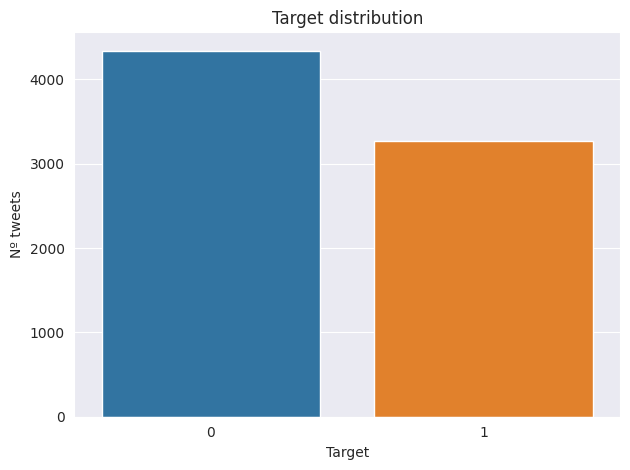

In [11]:
# Target distribution
sns.countplot(data=df_train, x='target').set(xlabel='Target', ylabel='Nº tweets', title= 'Target distribution')
plt.tight_layout()

In [12]:
print(f"Percentage of non-disaster tweets: {int(df_train['target'].value_counts(True)[0]*100)}%")
print(f"Percentage of disaster tweets: {int(df_train['target'].value_counts(True)[1]*100)}%")

Percentage of non-disaster tweets: 57%
Percentage of disaster tweets: 42%


As can be seen, there is a higher percentage of tweets that are categorised as false disasters. However, this difference is minimal (15%) so we will continue to consider that the distribution of the target variable is balanced.

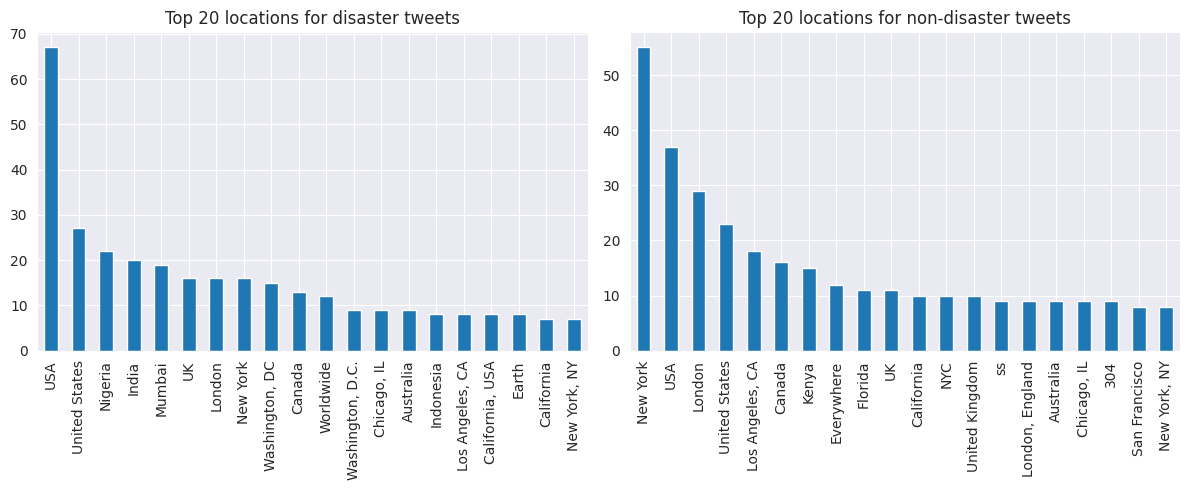

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

df_train[df_train['target']==1]['location'].value_counts()[:20].plot(kind='bar', ax=ax[0])
ax[0].set_title('Top 20 locations for disaster tweets')

df_train[df_train['target']!=1]['location'].value_counts()[:20].plot(kind='bar', ax=ax[1])
ax[1].set_title('Top 20 locations for non-disaster tweets')

plt.tight_layout()

Most of the tweets are of American origin, either referring to the country or one of its cities. As we can see, it is necessary a process of formating because there are different formats to name `New York` and others that refer to nowhere. 

Next, we are going to carry out a cleaning exercise to eliminate those stop words, punctuation marks, mentions, etc. that do not contribute meaning or value to the tweet (sentences in `text` variable) in this case. To do this, we must first tokenize each of the tweets.

In [14]:
def cleanReviews(text):
  '''
    Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.
    
    Args: 
        text (string): text to introduce
    Returns:
        string: cleaned text
  '''
  
  text = re.sub('@[A-Za-z0-9_]+', '', text) 
  text = re.sub('#','',text) 
  text = re.sub('RT[\s]+','',text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('\n',' ',text)
  text = re.sub("[^-9A-Za-z ]", "" , text) 
  text = re.sub("\s+"," ", text)
  return text.lower()

In [15]:
df_train['cleaned_tweets'] = df_train['text'].apply(cleanReviews) 
df_test['cleaned_tweets'] = df_test['text'].apply(cleanReviews)

print(f"Tweet before cleaning: {df_train['text'][100]}")
print("----------------------\n")
print(f"Tweet after cleaning:{df_train['cleaned_tweets'][100]}")
print("---------------------\n")

Tweet before cleaning: .@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad
----------------------

Tweet after cleaning: bahrain police had previously died in a road accident they were not killed by explosion 
---------------------



In [16]:
def tokenizer_stop_words(text):
    '''
    Tokenizes the input text and returns a list of words. 
    Uses Python's NLTK library for tokenization.
    
    Args:
        text (str): Text string to be tokenized.
        
    Returns:
        list: List of tokenized words.
    '''
    
    w_token = word_tokenize(text)
    return w_token

In [17]:
# Stop words corpus 
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(nltk.corpus.stopwords.words('english'))

# For test data set
df_train['words_tokenized']=df_train['cleaned_tweets'].apply(tokenizer_stop_words)
df_train['clean_stopwords'] = df_train['cleaned_tweets'].apply(lambda x:' '.join([word for word in x.split(' ') if word not in stop_words]))

# For test data set
df_test['words_tokenized']=df_test['cleaned_tweets'].apply(tokenizer_stop_words)
df_test['clean_stopwords'] = df_test['cleaned_tweets'].apply(lambda x:' '.join([word for word in x.split(' ') if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Below we can see the process and how has been executed inside training set.

In [18]:
df_train.head()

,id,keyword,location,text,target,cleaned_tweets,words_tokenized,clean_stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...",got sent photo ruby alaska smoke wildfires pou...


The next step is to look at the distribution of both words and characters used in tweets and also the most common unigrams in disaster and non-disaster tweets.

In [19]:
# Chart count
df_train['char_count'] = df_train['clean_stopwords'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['clean_stopwords'].apply(lambda x: len(str(x)))

# Word count
df_train['word_count'] = df_train['words_tokenized'].apply(lambda x: len(x))
df_test['word_count'] = df_test['words_tokenized'].apply(lambda x: len(x))

In [20]:
def train_vs_test(df, title):
  '''
  Plots histograms of word and character counts for training and test datasets.

    Args:
    - df (pandas.DataFrame): Dataframe containing the data to plot.
    - title (str): Title of the plot.

    Returns:
    - defined chart
  '''
  
  fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

  if 'train' in title:
    sns.histplot(x = df['word_count'], data=df, hue = 'target', kde=True, ax = ax[0])
    ax[0].set_title(f"Word count in {title}")

    sns.histplot(x = df['char_count'], data=df, hue = 'target', kde=True, ax = ax[1])
    ax[1].set_title(f"Chart count in {title}")

    plt.tight_layout()
  
  else:
    sns.histplot(x = df['word_count'], data=df, kde=True, ax = ax[0])
    ax[0].set_title(f"Word count in {title}")

    sns.histplot(x = df['char_count'], data=df, kde=True, ax = ax[1])
    ax[1].set_title(f"Chart count in {title}")

    plt.tight_layout()

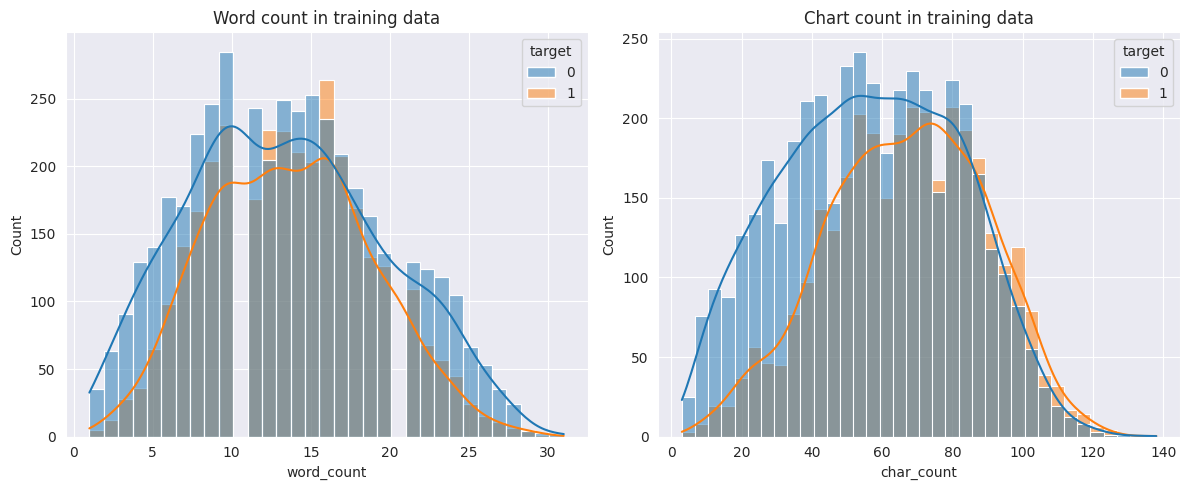

In [21]:
train_vs_test(df_train, 'training data')

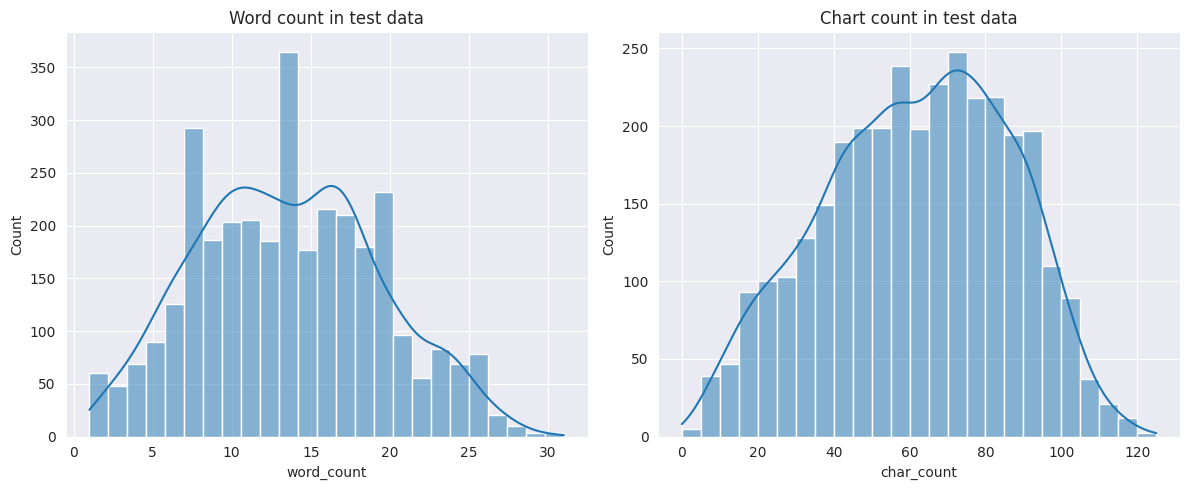

In [22]:
train_vs_test(df_test, 'test data')

Similar distributions can be observed for both training and test data when referring to the number of words and characters within tweets.

Within the training dataset, if we filter by the target, we do not observe much difference in their distributions either. We do see that there are more fake tweets, but that is something we have already mentioned before.

In [23]:
def generate_ngrams(text, n_gram=1):
  """
  Generate n-grams from a given text.

  Args:
      text (str): Input text to generate n-grams from.
      n_gram (int): Number of tokens to include in each n-gram. Defaults to 1.

  Returns:
    list: List of n-grams generated from the input text.

  Example:
    >>> generate_ngrams("The quick brown fox jumps over the lazy dog", n_gram=2)
     ['The quick', 'quick brown', 'brown fox', 'fox jumps', 'jumps over', 'over the', 'the lazy', 'lazy dog']
  """

  token = [token for token in text.split(' ') if (token != '') & (token != '-')]
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  return [' '.join(ngram) for ngram in ngrams]

In [24]:
def data_collection(column):
  """
  Collects data and creates dataframes of the most frequent keywords or unigrams in disaster and non-disaster tweets.

  Args:
  - column (str): Indicates the column of the dataframe to use for collecting data. Must be either 'keyword' or 'clean_stopwords'.

  Returns:
  - returns two dataframes:
      1. Dataframe 1 (pandas.DataFrame): Contains the most frequent unigrams/keywords in disaster tweets, along with their frequency count.
      2. dataframe 2 (pandas.DataFrame): Contains the most frequent unigrams/keywords in non-disaster tweets, along with their frequency count.
  """

  # Create the dictionaries to store the count of unigrams
  disaster_keywords = defaultdict(int) 
  nondisaster_keywords = defaultdict(int)
  disaster_unigrams = defaultdict(int) 
  nondisaster_unigrams = defaultdict(int)

  if column == 'clean_stopwords':
    # Loop over disaster tweets in the training dataset and count their unigrams
    for tweet in df_train[df_train['target']==1][column]:
        for word in generate_ngrams(tweet):
            disaster_unigrams[word] += 1

    # Loop over non-disaster tweets in the training dataset and count their unigrams
    for tweet in df_train[df_train['target']!=1][column]:
        for word in generate_ngrams(tweet):
            nondisaster_unigrams[word] += 1

    # Create their respective dataframes
    ngram_disaster = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
    ngram_nondisaster = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

    return ngram_disaster, ngram_nondisaster

  else:
    # Loop over disaster tweets in the training dataset and count their unigrams
    for keyword in df_train[df_train['target']==1][column]:
      disaster_keywords[keyword] += 1

    # Loop over non-disaster tweets in the training dataset and count their unigrams
    for keyword in df_train[df_train['target']!=1][column]:
      nondisaster_keywords[keyword] += 1  

    # Create their respective dataframes
    keyword_disaster = pd.DataFrame(sorted(disaster_keywords.items(), key=lambda x: x[1])[::-1])
    keyword_nondisaster = pd.DataFrame(sorted(nondisaster_keywords.items(), key=lambda x: x[1])[::-1])

    return keyword_disaster, keyword_nondisaster

In [25]:
def plot_top(df_disaster, df_nondisaster, n, name):
  """
  Plots bar charts of the top N most common keywords or unigrams in disaster and non-disaster tweets.

  Args:
  - df_disaster (pandas.DataFrame): Contains the most frequent keywords or unigrams in disaster tweets, along with their frequency count.
  - df_nondisaster (pandas.DataFrame): Contains the most frequent keywords or unigrams in non-disaster tweets, along with their frequency count.
  - n (int): Specifies the number of top keywords or unigrams to display on the bar charts.
  - name (str): Indicates whether the data being plotted are 'keywords' or 'unigrams'.

  Returns:
  - Displays the bar charts of the top N most common keywords or unigrams in disaster and non-disaster tweets.
  """

  # Bar charts of top 20 words in disaster/non-disaster tweets
  fig, axes = plt.subplots(ncols=2, figsize=(18, 8), dpi=100)
  plt.tight_layout()

  sns.barplot(y=df_disaster[0].values[:n], x=df_disaster[1].values[:n], ax=axes[0], color='red')
  sns.barplot(y=df_nondisaster[0].values[:n], x=df_nondisaster[1].values[:n], ax=axes[1], color='green')

  for i in range(2):
      axes[i].spines['right'].set_visible(False)
      axes[i].set_xlabel('Count')
      axes[i].tick_params(axis='x', labelsize=13)
      axes[i].tick_params(axis='y', labelsize=13)

  axes[0].set_title(f'Top {n} most common {name} in Disaster Tweets', fontsize=15)
  axes[1].set_title(f'Top {n} most common {name} in Non-disaster Tweets', fontsize=15)

  plt.show()

In [26]:
data_key_disaster, data_key_nondisaster = data_collection('keyword')
data_ngram_disaster, data_ngram_nondisaster = data_collection('clean_stopwords')

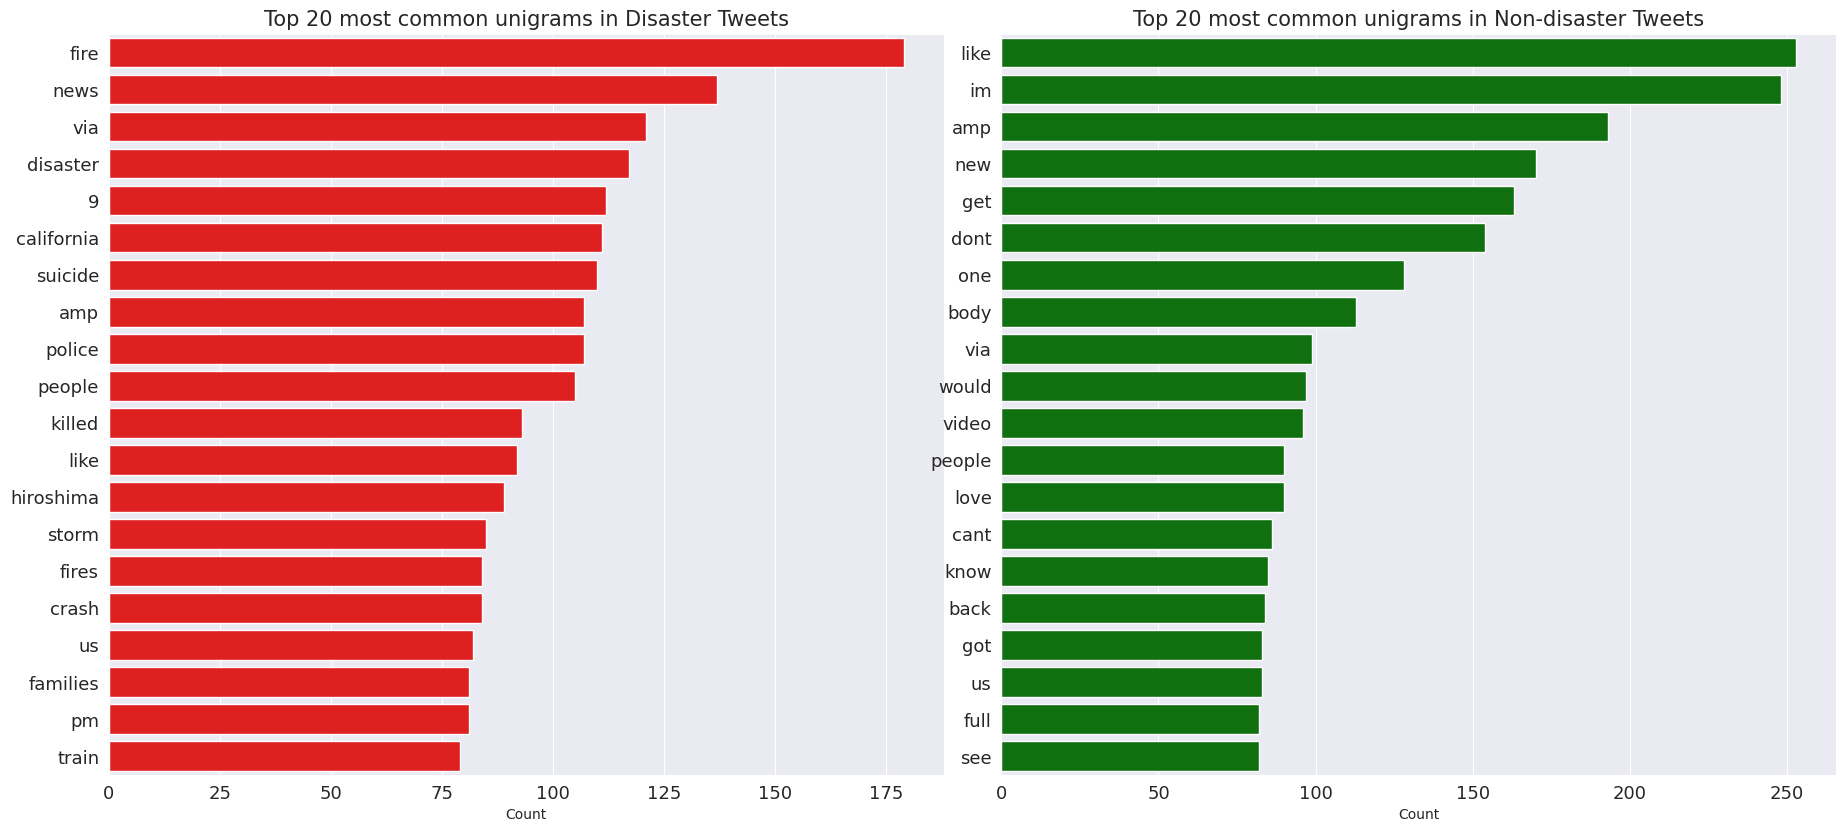

In [27]:
plot_top(data_ngram_disaster, data_ngram_nondisaster, 20, 'unigrams')

The following graph shows the top 20 unigrams for tweets that talk about disasters and those that do not.

A remarkable fact is that the word "**_like_**" is within this ranking in both types of tweet. That is why it is important when predicting to take into account the order and meaning of the sentence as we will see below.

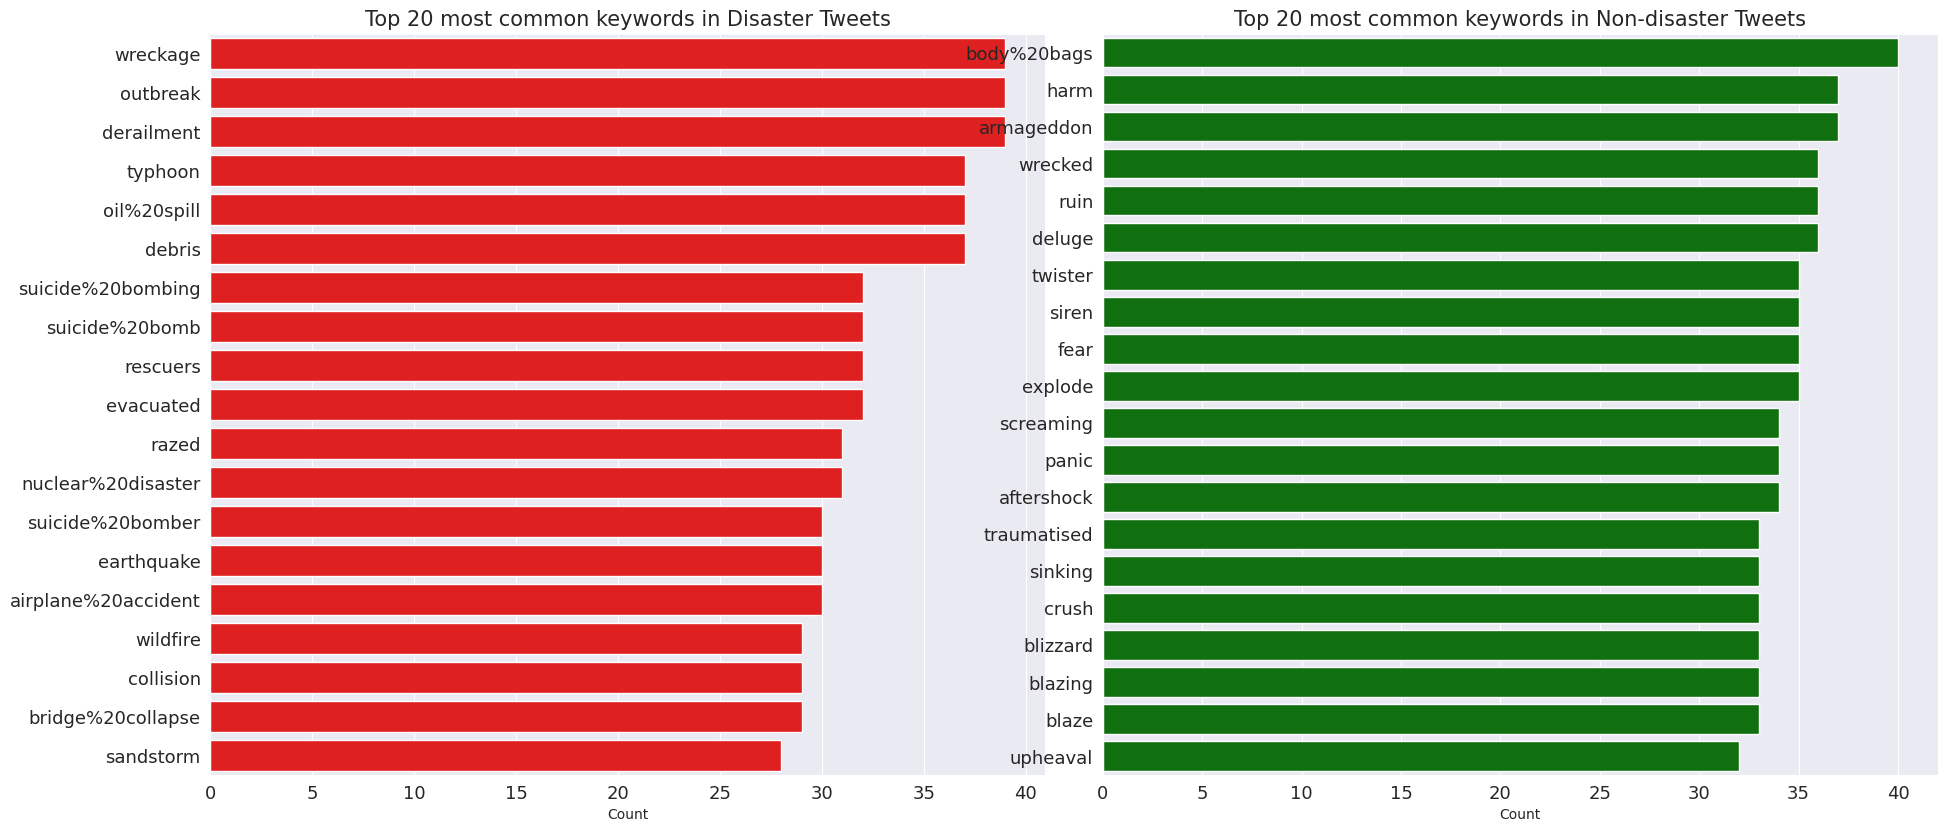

In [28]:
plot_top(data_key_disaster, data_key_nondisaster, 20, 'keywords')

As can be seen in the barplot, tweets referring to disasters have in some part of the keyword the unigram _'suicide'_ or _'bomb'_, being these the most frequent ones. 

In the part of the tweets that talk about non-disasters, there are keywords such as harm, armageddon or wrecked that could confuse the model if we carry out stemming or the process of lemmatization by its root _**'wreck'**_, since _'wreckage'_ appears in the top of the tweets referring to disasters.

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 50px;">4. Modeling ⚙️ </p>

We will evaluate four types of models, which will be three neural network models (CNN, LSTM and GRU) and another popular NLP modelling type (BERT) with pre-trained models within its library.

Each model has been adjusted after several tweaked process with its best parameters to obtain the best results without over-adjustment and focusing on accuracy.

In [29]:
# Splitting training set into 'training' and 'test sets
data_train = df_train[:int(df_train.shape[0]*0.75)]
data_test = df_train[int(df_train.shape[0]*0.75):]

# Maximum length of all tweets
max_len = max([len(x.split(' ')) for x in df_train['cleaned_tweets']])

_Defining some useful global variables:_

Next you will define some global variables that will be used throughout the assignment.

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. We will use 100 due tu Glove vector's dimension.


- `MAXLEN`: Maximum length of all sequences. We will take 128.


- `TRUNCATING`: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of observations.
    
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.75.

In [30]:
# Initialise the variables
EMBEDDING_DIM = 100 
MAXLEN = max_len 
TRUNCATING = 'post'
PADDING = 'post'
MAX_EXAMPLES = len(data_train)
OOV_TOKEN = 'OOV'
DATA_TRAINING = data_train['cleaned_tweets'].to_list()
DATA_TEST = data_test['cleaned_tweets'].to_list()

In [31]:
# Instantiate the Tokenizer class, passing in the correct values for oov_token
tokenizer = Tokenizer(num_words = MAX_EXAMPLES, oov_token = OOV_TOKEN) 

# Fit the tokenizer to the training sentences
tokenizer.fit_on_texts(DATA_TRAINING)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Number of unique words:', vocab_size)

Number of unique words: 12221


In [32]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """  
         
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding, truncating = truncating)
    
    return pad_trunc_sequences

In [33]:
# Executing our function for both sets
train_pad_trunc_seq = seq_pad_and_trunc(DATA_TRAINING, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(DATA_TEST, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [34]:
train_labels = np.array(data_train['target'])
test_labels = np.array(data_test['target'])

We will save the vector representation of each word in the vocabulary in a numpy array. In this case we use pre-trained vector of different words from [GloVe](https://nlp.stanford.edu/projects/glove/), In particular the 100 dimensions version.

A couple of things to notice in the code below:
- If a word in your vocabulary is not present in `glove_embeddings` the representation for that word is left as a column of zeros.
- `word_index` starts counting at 1, because of this you will need to add an extra column at the left-most side of the `embedding_matrix` array. This is the reason why you add 1 to `vocab_size` in the cell below:

In [35]:
# Initialize an empty embeddings index dictionary
glove_embeddings = {}
glove_twitter = '/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.100d.txt'

# Read file and fill glove_embeddings with its contents
with open(glove_twitter) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [36]:
# Initialize an empty numpy array with the appropriate size
embedding_matrix = np.zeros((vocab_size+1, 100))

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.1 CNN model 🤖</p>

Firstly, we will use a convolution layer to extract features from dataset. We will append a GlobalAveragePooling1d layer to reduce the results before passing it on to the dense layers. Also we will use dropout layers to reduce the percentage of neurons in that layer and therefore reduce overfitting.

In [357]:
# Model Definition with CNN
cnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[embedding_matrix], trainable=False), 
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-5),
                  metrics=['accuracy'])

In [358]:
# Create untrained model
cnn_model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 31, 100)           1222200   
                                                                 
 conv1d_30 (Conv1D)          (None, 27, 128)           64128     
                                                                 
 global_max_pooling1d_28 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_193 (Dense)           (None, 512)               66048     
                                                                 
 dense_194 (Dense)           (None, 1)                 513       
                                                                 
Total params: 1,352,889
Trainable params: 130,689
Non-trainable params: 1,222,200
_____________________________________

In [173]:
# Train the model and save the training history
history_cnn = cnn_model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, test_labels))

Epoch 1/20
179/179 [==============================] - 2s 5ms/step - loss: 0.6692 - accuracy: 0.5989 - val_loss: 0.6604 - val_accuracy: 0.5977
Epoch 2/20
179/179 [==============================] - 1s 4ms/step - loss: 0.6384 - accuracy: 0.6677 - val_loss: 0.6319 - val_accuracy: 0.6786
Epoch 3/20
179/179 [==============================] - 1s 4ms/step - loss: 0.6119 - accuracy: 0.7187 - val_loss: 0.6048 - val_accuracy: 0.7327
Epoch 4/20
179/179 [==============================] - 1s 5ms/step - loss: 0.5875 - accuracy: 0.7425 - val_loss: 0.5823 - val_accuracy: 0.7416
Epoch 5/20
179/179 [==============================] - 1s 4ms/step - loss: 0.5647 - accuracy: 0.7502 - val_loss: 0.5574 - val_accuracy: 0.7579
Epoch 6/20
179/179 [==============================] - 1s 4ms/step - loss: 0.5454 - accuracy: 0.7616 - val_loss: 0.5439 - val_accuracy: 0.7532
Epoch 7/20
179/179 [==============================] - 1s 5ms/step - loss: 0.5288 - accuracy: 0.7651 - val_loss: 0.5315 - val_accuracy: 0.7542
Epoch 

In [174]:
# Plot history curves function
def plot_learning_evolution(model):
    '''Function that plots the learning evolution of a model.

    Args:
        model (keras.models.Model): The trained model to plot.

    Returns:
        The function only displays the plot.
    '''

    df = pd.DataFrame(model.history)
    df.index = df.index + 1
    plt.figure(figsize = (12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(df['loss'], label = 'Loss')
    plt.plot(df['val_loss'], label = 'Val_Loss')
    plt.xlabel("Epochs")
    plt.xticks(df.index)
    plt.ylabel("Loss")
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(df['accuracy'], label = 'Accuracy')
    plt.plot(df['val_accuracy'], label = 'Test_accuracy')
    plt.xlabel("Epochs")
    plt.xticks(df.index)
    plt.ylabel("Accuracy")
    plt.title('Accuracy score evolution during training')
    plt.legend();

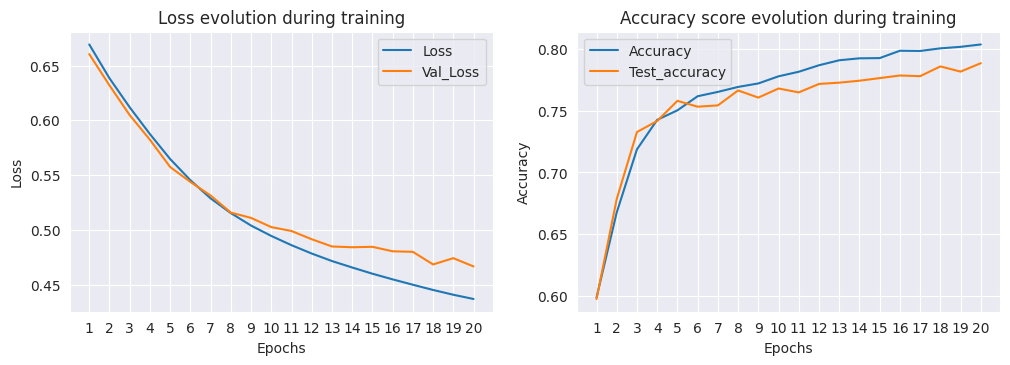

In [175]:
plot_learning_evolution(history_cnn)

In [354]:
# Evaluation of CNN model
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(val_pad_trunc_seq, test_labels)

print(f"Test Loss: {test_loss_cnn:.4f}")
print(f"Test Accuracy: {test_acc_cnn:.4f}")

60/60 [==============================] - 0s 4ms/step - loss: 0.4668 - accuracy: 0.7883
Test Loss: 0.4668
Test Accuracy: 0.7883


Above we can see the evolution graphs during training for both the accuracy and the loss curve. The CNN works very well for the training data, exceeding 80% for all 20 epochs. 

For the validation (test) data, the curve almost overlaps with the training curve up to epoch 4-5. It reaches a maximum of about 78% accuracy.

Notice that there is no overfitting, since the slope of the loss curve being negative throughout the modeling.

<a id='4.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.2 RNN (LSTM layers) model 🤖</p>

The big difference between CNNs and RNN [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) is that the latter are more useful for processing sequential data. We will see how it works.

In [359]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy', 
                   optimizer=RMSprop(learning_rate=1e-5), 
                   metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 31, 100)           1222200   
                                                                 
 bidirectional_42 (Bidirecti  (None, 31, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_43 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_195 (Dense)           (None, 512)               33280     
                                                                 
 dense_196 (Dense)           (None, 1)                 513       
                                                                 
Total params: 1,381,689
Trainable params: 159,489
Non

In [360]:
history_lstm = model_lstm.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, test_labels))

Epoch 1/20
179/179 [==============================] - 12s 21ms/step - loss: 0.6889 - accuracy: 0.5614 - val_loss: 0.6841 - val_accuracy: 0.5562
Epoch 2/20
179/179 [==============================] - 3s 15ms/step - loss: 0.6767 - accuracy: 0.5857 - val_loss: 0.6742 - val_accuracy: 0.5593
Epoch 3/20
179/179 [==============================] - 3s 17ms/step - loss: 0.6642 - accuracy: 0.5980 - val_loss: 0.6622 - val_accuracy: 0.5919
Epoch 4/20
179/179 [==============================] - 2s 12ms/step - loss: 0.6501 - accuracy: 0.6535 - val_loss: 0.6474 - val_accuracy: 0.6539
Epoch 5/20
179/179 [==============================] - 2s 12ms/step - loss: 0.6328 - accuracy: 0.7054 - val_loss: 0.6283 - val_accuracy: 0.7012
Epoch 6/20
179/179 [==============================] - 2s 12ms/step - loss: 0.6132 - accuracy: 0.7334 - val_loss: 0.6075 - val_accuracy: 0.7327
Epoch 7/20
179/179 [==============================] - 2s 12ms/step - loss: 0.5921 - accuracy: 0.7408 - val_loss: 0.5851 - val_accuracy: 0.747

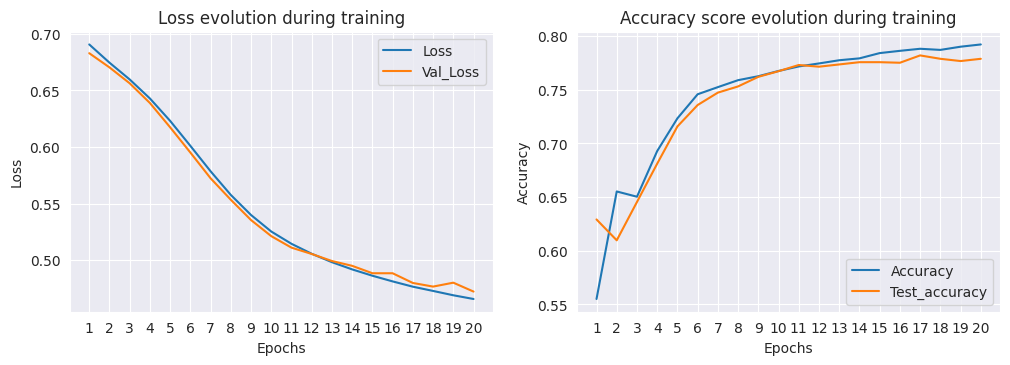

In [178]:
plot_learning_evolution(history_lstm)

In [361]:
# Evaluation of LSTM model
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(val_pad_trunc_seq, test_labels)

print(f"Test Loss: {test_loss_lstm:.4f}")
print(f"Test Accuracy: {test_acc_lstm:.4f}")

60/60 [==============================] - 0s 6ms/step - loss: 0.4673 - accuracy: 0.7794
Test Loss: 0.4673
Test Accuracy: 0.7794


In the RNN LSTM, the test curve is still better than the training curve, both in the loss graph and in the accuracy graph, where a maximum value of around 80% is reached in both curves.

<a id='4.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.3 RNN (GRU layers) model 🤖</p>

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but if you want faster results and can sacrifice some accuracy. We will notice it trains faster than LSTM model by a few seconds.

In [179]:
# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=1e-5), 
                  metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 31, 100)           1222200   
                                                                 
 bidirectional_38 (Bidirecti  (None, 31, 128)          63744     
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 64)               31104     
 onal)                                                           
                                                                 
 dense_156 (Dense)           (None, 512)               33280     
                                                                 
 dense_157 (Dense)           (None, 1)                 513       
                                                                 
Total params: 1,350,841
Trainable params: 128,641
Non

In [180]:
history_gru = model_gru.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, test_labels))

Epoch 1/20
179/179 [==============================] - 11s 22ms/step - loss: 0.6815 - accuracy: 0.5894 - val_loss: 0.6705 - val_accuracy: 0.5987
Epoch 2/20
179/179 [==============================] - 3s 18ms/step - loss: 0.6632 - accuracy: 0.6115 - val_loss: 0.6553 - val_accuracy: 0.6108
Epoch 3/20
179/179 [==============================] - 3s 18ms/step - loss: 0.6477 - accuracy: 0.6325 - val_loss: 0.6400 - val_accuracy: 0.6570
Epoch 4/20
179/179 [==============================] - 3s 15ms/step - loss: 0.6310 - accuracy: 0.6716 - val_loss: 0.6221 - val_accuracy: 0.6922
Epoch 5/20
179/179 [==============================] - 2s 11ms/step - loss: 0.6121 - accuracy: 0.6982 - val_loss: 0.6015 - val_accuracy: 0.7195
Epoch 6/20
179/179 [==============================] - 3s 14ms/step - loss: 0.5925 - accuracy: 0.7183 - val_loss: 0.5805 - val_accuracy: 0.7216
Epoch 7/20
179/179 [==============================] - 3s 17ms/step - loss: 0.5746 - accuracy: 0.7288 - val_loss: 0.5642 - val_accuracy: 0.732

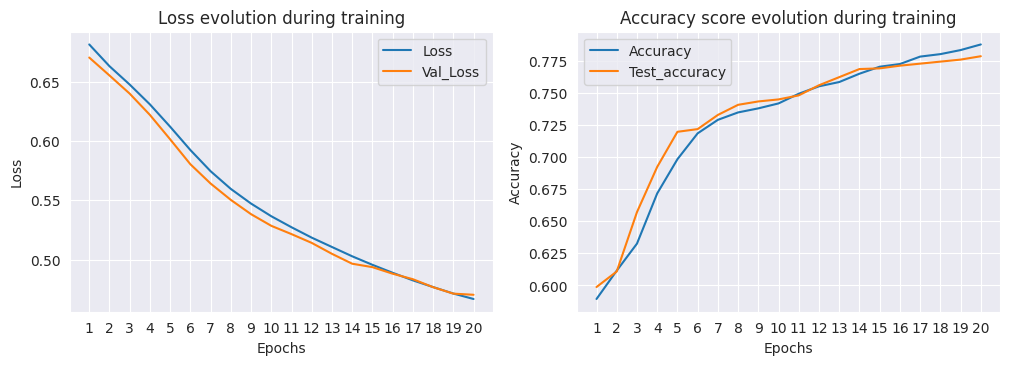

In [181]:
plot_learning_evolution(history_gru)

In [356]:
# Evaluation of GRU model
test_loss_gru, test_acc_gru = model_gru.evaluate(val_pad_trunc_seq, test_labels)

print(f"Test Loss: {test_loss_gru:.4f}")
print(f"Test Accuracy: {test_acc_gru:.4f}")

60/60 [==============================] - 0s 6ms/step - loss: 0.4704 - accuracy: 0.7784
Test Loss: 0.4704
Test Accuracy: 0.7784


The results are almost similar to those of the LSTM model.

<a id='4.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.4 BERT model 🤖</p>

[BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=es-419) is a powerful natural language processing model that is part of the transformer library, which was developed by [Hugging Face AI](https://huggingface.co) where we can find a thousands of pre-trained models. Its ability to accurately understand the context and meaning of words has made it a popular choice for various NLP tasks, including sentiment analysis and language translation.

In [248]:
# Function to encode our data into BERT format
def bert_encode(data, maximum_length):
    """
    Encodes the input text data using the BERT tokenizer to produce input IDs and attention masks.
    
    Args:
    - data (list): List of input texts to encode.
    - maximum_length (int): Maximum sequence length of the encoded text. Inputs will be truncated or padded to this length.
    
    Returns:
    - input_ids (numpy array): Array of input IDs of shape (num_samples, maximum_length).
    - attention_masks (numpy array): Array of attention masks of shape (num_samples, maximum_length).
    """
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [249]:
# Generating training data 
texts = DATA_TRAINING

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_input_ids, train_attention_masks = bert_encode(texts, MAXLEN)

In [250]:
def create_model(bert_model):
    """
    Creates a custom neural network model using a pre-trained BERT model as a base.

    Args:
    - bert_model: Pre-trained BERT model to use as a base for the custom model.

    Returns:
    - model: Custom neural network model built on top of the pre-trained BERT model.
    """

    # Define two input layers for the BERT model's input_ids and attention_masks
    input_ids = tf.keras.Input(shape=(MAXLEN,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(MAXLEN,),dtype='int32')

    # Pass the input layers through the BERT model
    output = bert_model([input_ids,attention_masks])
    
    # Take only the pooled output of the BERT model
    output = output[1]

    # Add two dense layers to the output of the BERT model
    output = tf.keras.layers.Dense(512,activation='relu')(output)

    # Add two dense layers
    output = tf.keras.layers.Dense(256,activation='relu')(output) #256

    # Add a final dense layer with sigmoid activation for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    # Define the inputs and outputs of the custom model
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    # Compile the model using binary cross-entropy loss and accuracy as metrics
    model.compile(RMSprop(learning_rate=8e-7), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [251]:
# Creating the object bert_model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [252]:
BERT_model = create_model(bert_model)
BERT_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 tf_bert_model_13 (TFBertModel)  TFBaseModelOutputWi  109482240  ['input_27[0][0]',               
                                thPoolingAndCrossAt               'input_28[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 31,                                         

In [253]:
# Training the model
history_BERT = BERT_model.fit(
    [train_input_ids, train_attention_masks],
    train_labels,
    validation_split=0.2, 
    epochs=20,
    batch_size=32
)

Epoch 1/20
143/143 [==============================] - 85s 322ms/step - loss: 0.7236 - accuracy: 0.4692 - val_loss: 0.6811 - val_accuracy: 0.6296
Epoch 2/20
143/143 [==============================] - 35s 244ms/step - loss: 0.6572 - accuracy: 0.6716 - val_loss: 0.6444 - val_accuracy: 0.6891
Epoch 3/20
143/143 [==============================] - 36s 249ms/step - loss: 0.6158 - accuracy: 0.7300 - val_loss: 0.6051 - val_accuracy: 0.7356
Epoch 4/20
143/143 [==============================] - 36s 249ms/step - loss: 0.5654 - accuracy: 0.7637 - val_loss: 0.5625 - val_accuracy: 0.7469
Epoch 5/20
143/143 [==============================] - 34s 235ms/step - loss: 0.5160 - accuracy: 0.7856 - val_loss: 0.5320 - val_accuracy: 0.7557
Epoch 6/20
143/143 [==============================] - 35s 248ms/step - loss: 0.4809 - accuracy: 0.8001 - val_loss: 0.5106 - val_accuracy: 0.7609
Epoch 7/20
143/143 [==============================] - 36s 249ms/step - loss: 0.4555 - accuracy: 0.8080 - val_loss: 0.5015 - val_ac

In [254]:
# Store our metadata histories 
histories = {'CNN':history_cnn, 'LSTM':history_lstm, 'GRU':history_gru, 'BERT':history_BERT}

for key, value in histories.items():
    with open(f'{key}.pkl', 'wb') as f:
        pickle.dump(value.history, f)

In [255]:
from google.colab import files

# Nombre del archivo a descargar
file_name = ["CNN.pkl", "GRU.pkl", "LSTM.pkl", "BERT.pkl"]

for doc in file_name:
  files.download(doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

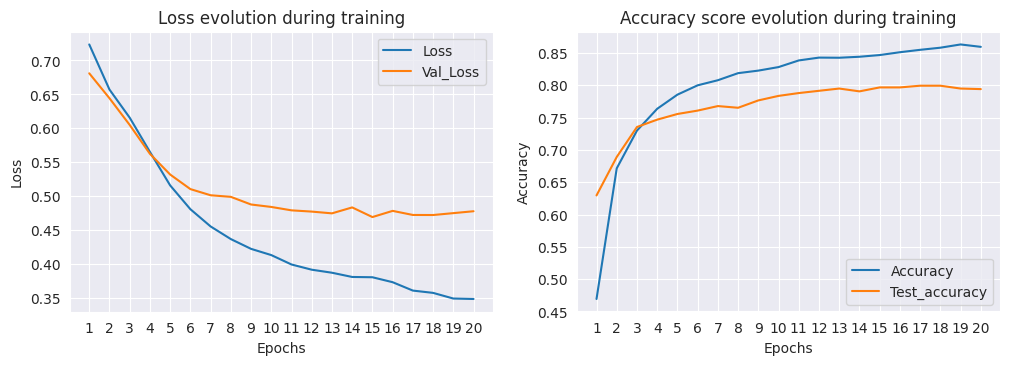

In [257]:
plot_learning_evolution(history_BERT)

The BERT model achieves higher accuracy, keeping the slope of the loss curve below zero. In addition, A simultaneous growth of the precision curves can also be observed.

In [288]:
# Create the inputs and mask for test 
val_input_ids, val_attention_masks = bert_encode(data_test['cleaned_tweets'].to_list(), MAXLEN)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [362]:
# Model evaluation with training data
train_loss_BERT, train_acc_BERT = BERT_model.evaluate(x=[train_input_ids, train_attention_masks], y=train_labels)

print(f"Test Loss: {train_loss_BERT:.4f}")
print(f"Test Accuracy: {train_acc_BERT:.4f}")

179/179 [==============================] - 15s 84ms/step - loss: 0.3497 - accuracy: 0.8641
Test Loss: 0.3497
Test Accuracy: 0.8641


In [363]:
# Model evaluation with validation data
val_loss_BERT, val_acc_BERT = BERT_model.evaluate(x=[val_input_ids, val_attention_masks], y=test_labels)

print(f"Test Loss: {val_loss_BERT:.4f}")
print(f"Test Accuracy: {val_acc_BERT:.4f}")

60/60 [==============================] - 5s 84ms/step - loss: 0.4078 - accuracy: 0.8246
Test Loss: 0.4078
Test Accuracy: 0.8246


<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 50px;">5. Submission 📤 </p>

We have selected BERT model because it has the best results in validation training set

In [312]:
# Create the inputs and mask for test 
test_input_ids, test_attention_masks = bert_encode(df_test['cleaned_tweets'].to_list(), MAXLEN)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [313]:
test_predict = BERT_model.predict([test_input_ids, test_attention_masks])

102/102 [==============================] - 9s 83ms/step


In [314]:
rounded_predict = np.where(test_predict > 0.5, 1, 0)

In [326]:
# Submission format dataframe
df_submission = pd.concat([df_test['id'], pd.Series(rounded_predict.flatten())], axis=1, keys=['id','target'])
df_submission.to_csv('submission_data.csv')
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Text(0.5, 1.0, 'Distribution of predictions with BERT model')

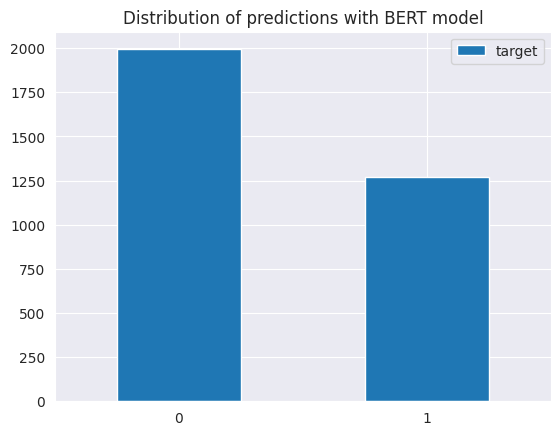

In [349]:
distr_df = pd.DataFrame(df_submission['target'].value_counts())
distr_df.plot(kind='bar')
plt.xticks(distr_df.index, rotation = 360);
plt.title('Distribution of predictions with BERT model')